In [ ]:
!pip install contextily
!pip install stackstac
!pip install pystac
!pip install pystac_client
!pip install planetary_computer
!pip install zarr
!pip install xarray[complete]

In [ ]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

# Geospatial
import contextily as cx
from shapely.geometry import Point, Polygon
import xarray as xr
import rasterio.features
import rasterio as rio
import fsspec

# API
import requests
import json

# Import Planetary Computer
import stackstac
import pystac
import pystac_client
import planetary_computer

# Other
import os
from itertools import cycle

# Folder to store extracted files
storage_path = './files/output/'

# Path to data folder with provided material
data_path = '/content'

In [ ]:
from google.colab import files, drive
import zipfile
import os

drive.mount('/content/drive')

# Specify the name of the zip file you uploaded
zip_filename = '/content/drive/MyDrive/Colab Notebooks/Info_Challenge/Level_1_GBIF_training_data.zip'

# Specify the directory where you want to extract the files
extract_dir = '/content/drive/MyDrive/Colab Notebooks/Info_Challenge/training_data/'

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the files from the zip archive
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:")
for file in extracted_files:
    print(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracted files:
dataset
rights.txt
metadata.xml
citations.txt
meta.xml
occurrence.txt
verbatim.txt
multimedia.txt


In [ ]:
def filter_bbox(frogs, bbox):
    frogs = frogs[lambda x:
        (x.decimalLongitude >= bbox[0]) &
        (x.decimalLatitude >= bbox[1]) &
        (x.decimalLongitude <= bbox[2]) &
        (x.decimalLatitude <= bbox[3])
    ]
    return frogs

def get_frogs(file, year_range=None, bbox=None):
    """Returns the dataframe of all frog occurrences for the bounding box specified."""
    columns = [
        'gbifID','eventDate','country','continent','stateProvince',
        'decimalLatitude','decimalLongitude','species'
    ]
    country_names = {
        'AU':'Australia', 'CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
        'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
        'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
        'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
    }
    continent_names = {
        'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
        'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
        'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
        'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid'
    }
    frogs = (
        pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Info_Challenge/training_data/occurrence.txt', sep='\t', parse_dates=['eventDate'])
        .assign(
            country =  lambda x: x.countryCode.map(country_names),
            continent =  lambda x: x.countryCode.map(continent_names),
            species = lambda x: x.species.str.title()
        )
        [columns]
    )
    if year_range is not None:
        frogs = frogs[lambda x:
            (x.eventDate.dt.year >= year_range[0]) &
            (x.eventDate.dt.year <= year_range[1])
        ]
    if bbox is not None:
        frogs = filter_bbox(frogs, bbox)
    return frogs

In [242]:
# Define the bounding box for Greater Sydney, NSW
region_name = 'Australia'
min_lon, min_lat = (112.0, -38.50)  # Lower-left corner
max_lon, max_lat = (153.0, -10.75)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# Load in data
all_frog_data = get_frogs('/content/drive/MyDrive/Colab Notebooks/Info_Challenge/training_data/occurrence.txt', year_range=(2015, 2019), bbox=bbox)

In [ ]:
all_frog_data

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax
116,2596664057,2018-11-28 00:00:00,Australia,Australia,Australian Capital Territory,-35.817770,148.936030,Crinia Signifera
...,...,...,...,...,...,...,...,...
193477,3108845537,2019-10-15 00:00:00,Australia,Australia,New South Wales,-33.718800,150.385000,Crinia Signifera
193482,3108845654,2019-09-21 00:00:00,Australia,Australia,New South Wales,-33.091900,151.465000,Litoria Fallax
193486,3108865868,2019-02-03 00:00:00,Australia,Australia,New South Wales,-34.028797,151.225626,Litoria Fallax
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax


In [ ]:
all_frog_data[all_frog_data['species']=='Litoria Fallax']

,gbifID,eventDate,country,continent,stateProvince,decimalLatitude,decimalLongitude,species
7,1944370584,2018-04-18 19:05:00,Australia,Australia,New South Wales,-33.693144,151.320884,Litoria Fallax
17,2423011701,2019-08-28 09:24:00,Australia,Australia,New South Wales,-33.925746,151.164082,Litoria Fallax
21,2236299662,2018-02-13 23:02:00,Australia,Australia,New South Wales,-31.732415,152.088515,Litoria Fallax
53,3031765405,2018-02-20 15:20:00,Australia,Australia,Queensland,-27.400618,152.800944,Litoria Fallax
521,2446280067,2018-01-22 00:00:00,Australia,Australia,New South Wales,-33.086880,151.420570,Litoria Fallax
...,...,...,...,...,...,...,...,...
193476,3108938525,2018-10-17 00:00:00,Australia,Australia,New South Wales,-33.757622,150.618240,Litoria Fallax
193482,3108845654,2019-09-21 00:00:00,Australia,Australia,New South Wales,-33.091900,151.465000,Litoria Fallax
193486,3108865868,2019-02-03 00:00:00,Australia,Australia,New South Wales,-34.028797,151.225626,Litoria Fallax
193507,3408189344,2019-12-24 21:22:00,Australia,Australia,Queensland,-26.754987,152.839291,Litoria Fallax


In [252]:
def plot_species(fig, ax, frog_data, region_name, cmap_params={'alpha':0.5}, scatter_params={'alpha':0.5}):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)

    # Colour cycle to ensure colors match in both plots
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude,
            frog_data[filt].decimalLatitude,
            marker='.',
            color=color['color'],
            **scatter_params
        )

    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    # ax[0].set_xticklabels([])
    # ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, **cmap_params) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()


def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

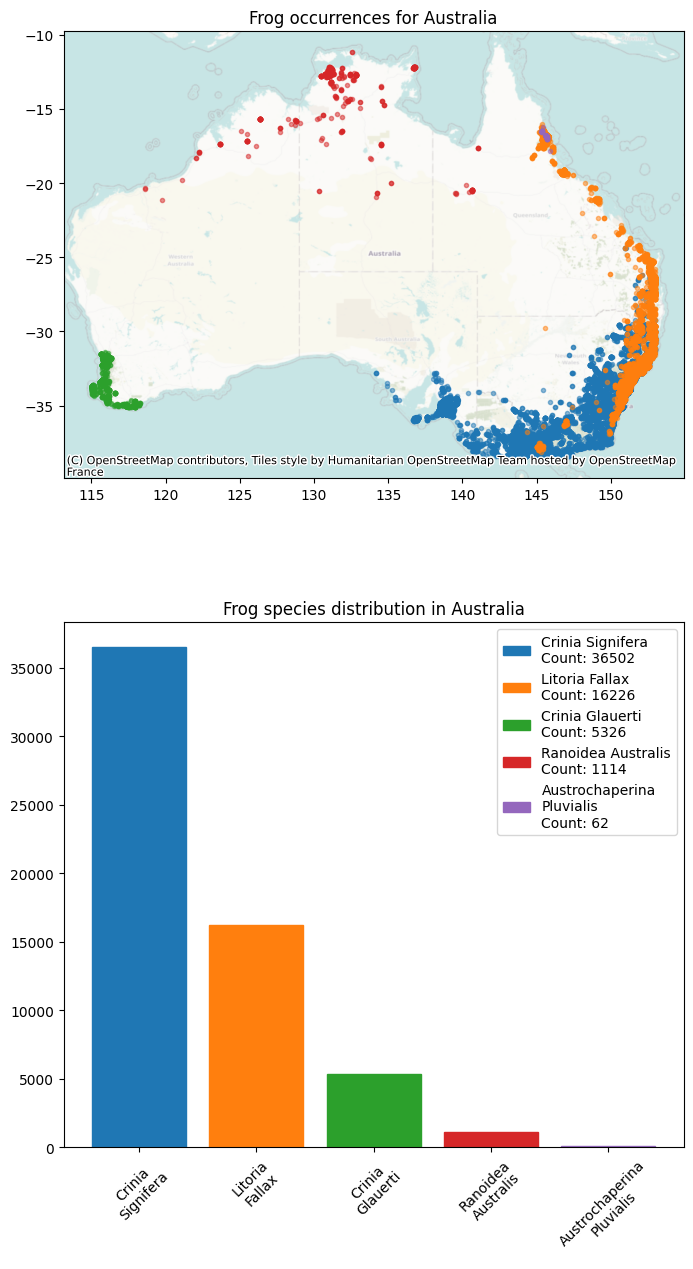

In [253]:
fig, ax = plt.subplots(2, 1, figsize=(8, 15))
plot_species(fig, ax, all_frog_data, region_name)

In [ ]:
target_species = 'Litoria Fallax'

all_frog_data = (
    all_frog_data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)

In [258]:
# Load in test coordinates
frog_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Info_Challenge/resampled_frog_data_15to19_new.csv')
frog_data = (frog_data
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)

Text(0.5, 1.0, 'Balanced training set')

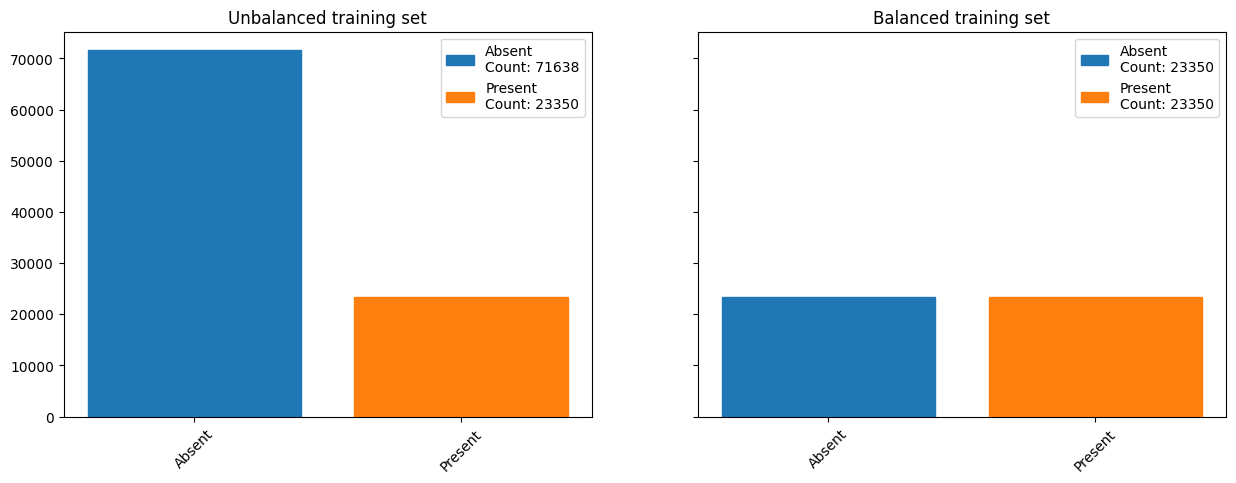

In [ ]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

Text(0.5, 1.0, 'Training set for Australia')

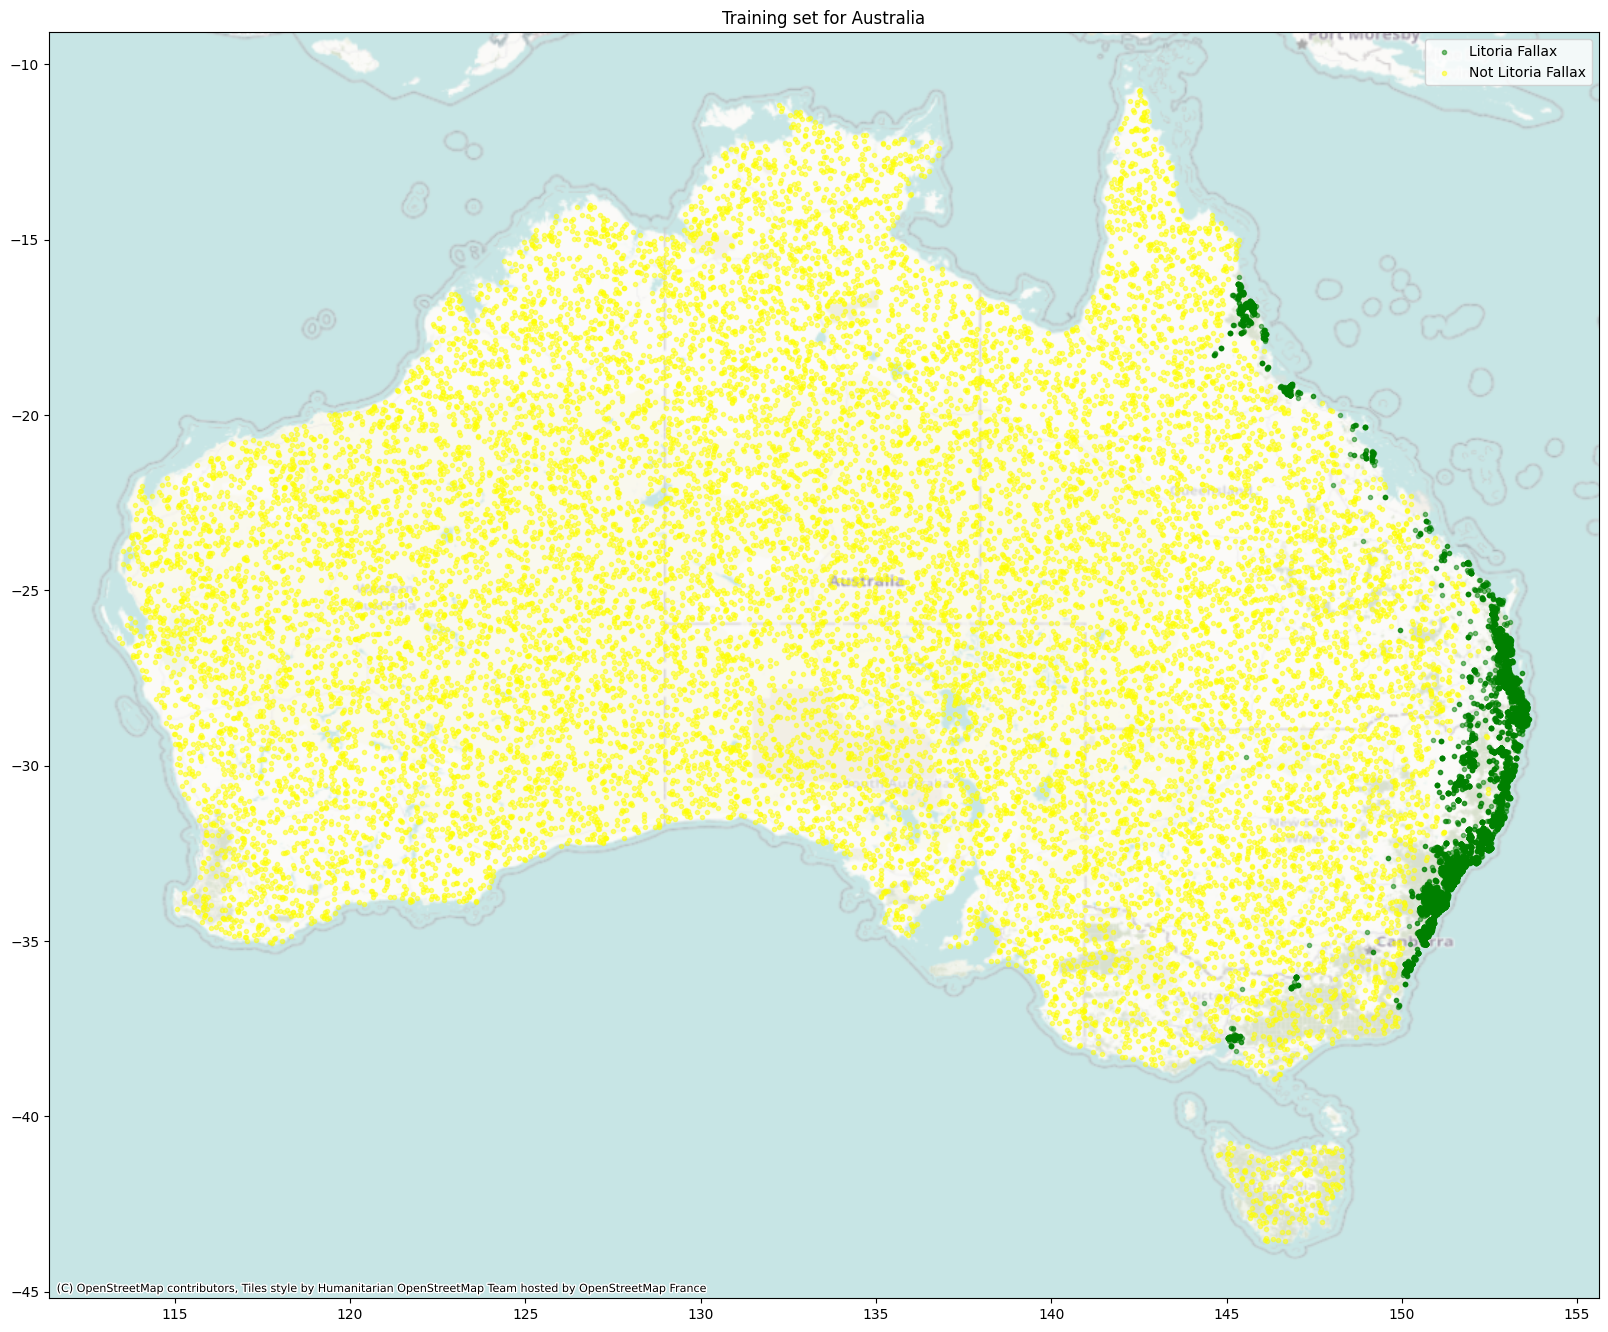

In [259]:
fig, ax = plt.subplots(figsize = (20, 20))

filt = frog_data.occurrenceStatus == 1
ax.scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
           color = 'green', marker='.', alpha=0.5, label=target_species)
ax.scatter(frog_data[~filt].decimalLongitude, frog_data[~filt].decimalLatitude,
           color = 'yellow', marker='.', alpha=0.5, label=f"Not {target_species}")
ax.legend()
cx.add_basemap(ax, crs={'init':'epsg:4326'}, alpha=0.5)
ax.set_title(f"Training set for {region_name}")

In [260]:
frog_data

,gbifID,eventDate,decimalLatitude,decimalLongitude,level0Gid,species,occurrenceStatus,Season,key
0,2.423012e+09,2019-08-28 09:24:00,-33.925746,151.164082,AUS,Litoria fallax,1,Winter,0
1,2.236300e+09,2018-02-13 23:02:00,-31.732415,152.088515,AUS,Litoria fallax,1,Summer,1
2,2.563750e+09,2017-10-25 21:07:00,-32.968624,151.644194,AUS,Litoria fallax,1,Spring,2
3,1.850994e+09,2017-11-30 08:35:00,-33.093048,151.416300,AUS,Litoria fallax,1,Spring,3
4,2.456512e+09,2016-04-17 11:12:00,-27.476426,152.977687,AUS,Litoria fallax,1,Autumn,4
...,...,...,...,...,...,...,...,...,...
36666,NaN,NaN,-16.877912,143.626021,AUS,Litoria fallax,0,NaN,36666
36667,NaN,NaN,-34.423030,138.619283,AUS,Litoria fallax,0,NaN,36667
36668,NaN,NaN,-12.577255,134.956561,AUS,Litoria fallax,0,NaN,36668
36669,NaN,NaN,-18.978658,136.122738,AUS,Litoria fallax,0,NaN,36669


In [ ]:
def get_terraclimate(bbox, metrics, time_slice=None, assets=None, features=None, interp_dims=None, verbose=True):
    """Returns terraclimate metrics for a given area, allowing results to be interpolated onto a larger image.

    Attributes:
    bbox -- Tuple of (min_lon, min_lat, max_lon, max_lat) to define area
    metrics -- Nested dictionary in the form {<metric_name>:{'fn':<metric_function>,'params':<metric_kwargs_dict>}, ... }
    time_slice -- Tuple of datetime strings to select data between, e.g. ('2015-01-01','2019-12-31')
    assets -- list of terraclimate assets to take
    features -- list of asset metrics to take, specified by strings in the form '<asset_name>_<metric_name>'
    interp_dims -- Tuple of dimensions (n, m) to interpolate results to
    """
    min_lon, min_lat, max_lon, max_lat = bbox

    collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
    asset = collection.assets["zarr-https"]
    store = fsspec.get_mapper(asset.href)
    data = xr.open_dataset(store, **asset.extra_fields["xarray:open_kwargs"])

    # Select datapoints that overlap region
    if time_slice is not None:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat),time=slice(time_slice[0],time_slice[1]))
    else:
        data = data.sel(lon=slice(min_lon,max_lon),lat=slice(max_lat,min_lat))
    if assets is not None:
        data = data[assets]
    print('Loading data') if verbose else None
    data = data.rename(lat='y', lon='x').to_array().compute()

    # Calculate metrics
    combined_values = []
    combined_bands = []
    for name, metric in metrics.items():
        print(f'Calculating {name}') if verbose else None
        sum_data = xr.apply_ufunc(
            metric['fn'], data, input_core_dims=[["time"]], kwargs=metric['params'], dask = 'allowed', vectorize = True
        ).rename(variable='band')
        xcoords = sum_data.x
        ycoords = sum_data.y
        dims = sum_data.dims
        combined_values.append(sum_data.values)
        for band in sum_data.band.values:
            combined_bands.append(band+'_'+name)

    # Combine metrics
    combined_values = np.concatenate(
        combined_values,
        axis=0
    )
    combined_data = xr.DataArray(
        data=combined_values,
        dims=dims,
        coords=dict(
            band=combined_bands,
            y=ycoords,
            x=xcoords
        )
    )

    # Take relevant bands:
    combined_data = combined_data.sel(band=features)

    if interp_dims is not None:
        print(f'Interpolating image') if verbose else None
        interp_coords = (np.linspace(bbox[0], bbox[2], interp_dims[0]), np.linspace(bbox[1], bbox[3], interp_dims[1]))
        combined_data = combined_data.interp(x=interp_coords[0], y=interp_coords[1], method='nearest', kwargs={"fill_value": "extrapolate"})

    return combined_data

In [261]:
# Metrics to measure over time dimension
tc_metrics = {
    'mean':{
        'fn':np.nanmean,
        'params':{}
    },
    'min':{
        'fn':np.nanmin,
        'params':{}
    },
    'max':{
        'fn':np.nanmax,
        'params':{}
    }
}

# Date range to take
time_slice = ('2015-01-01','2019-12-31')

# Measurements to take
assets=['tmax', 'tmin', 'ppt', 'soil', 'aet', 'def', 'vap', 'vpd']
# [Actual Evapotranspiration, climate Water Deficit, Vapour Pressure, VPD]
# [Actual Evapotranspiration, climate Water Deficit, Moisture Condition Index (MCI)]

# Features to take, in form '<asset>_<metric>'
features=['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean', 'def_mean', 'vap_mean', 'vpd_mean']

# Interpolate values to a 512x512 image
interp_dims = (512, 512)

weather_data = get_terraclimate(bbox, tc_metrics, time_slice=time_slice, assets=assets, features=features, interp_dims=interp_dims)
display(weather_data.band.values)

Loading data
Calculating mean
Calculating min
Calculating max
Interpolating image


array(['tmax_mean', 'tmin_mean', 'ppt_mean', 'soil_mean', 'aet_mean',
       'def_mean', 'vap_mean', 'vpd_mean'], dtype='<U9')

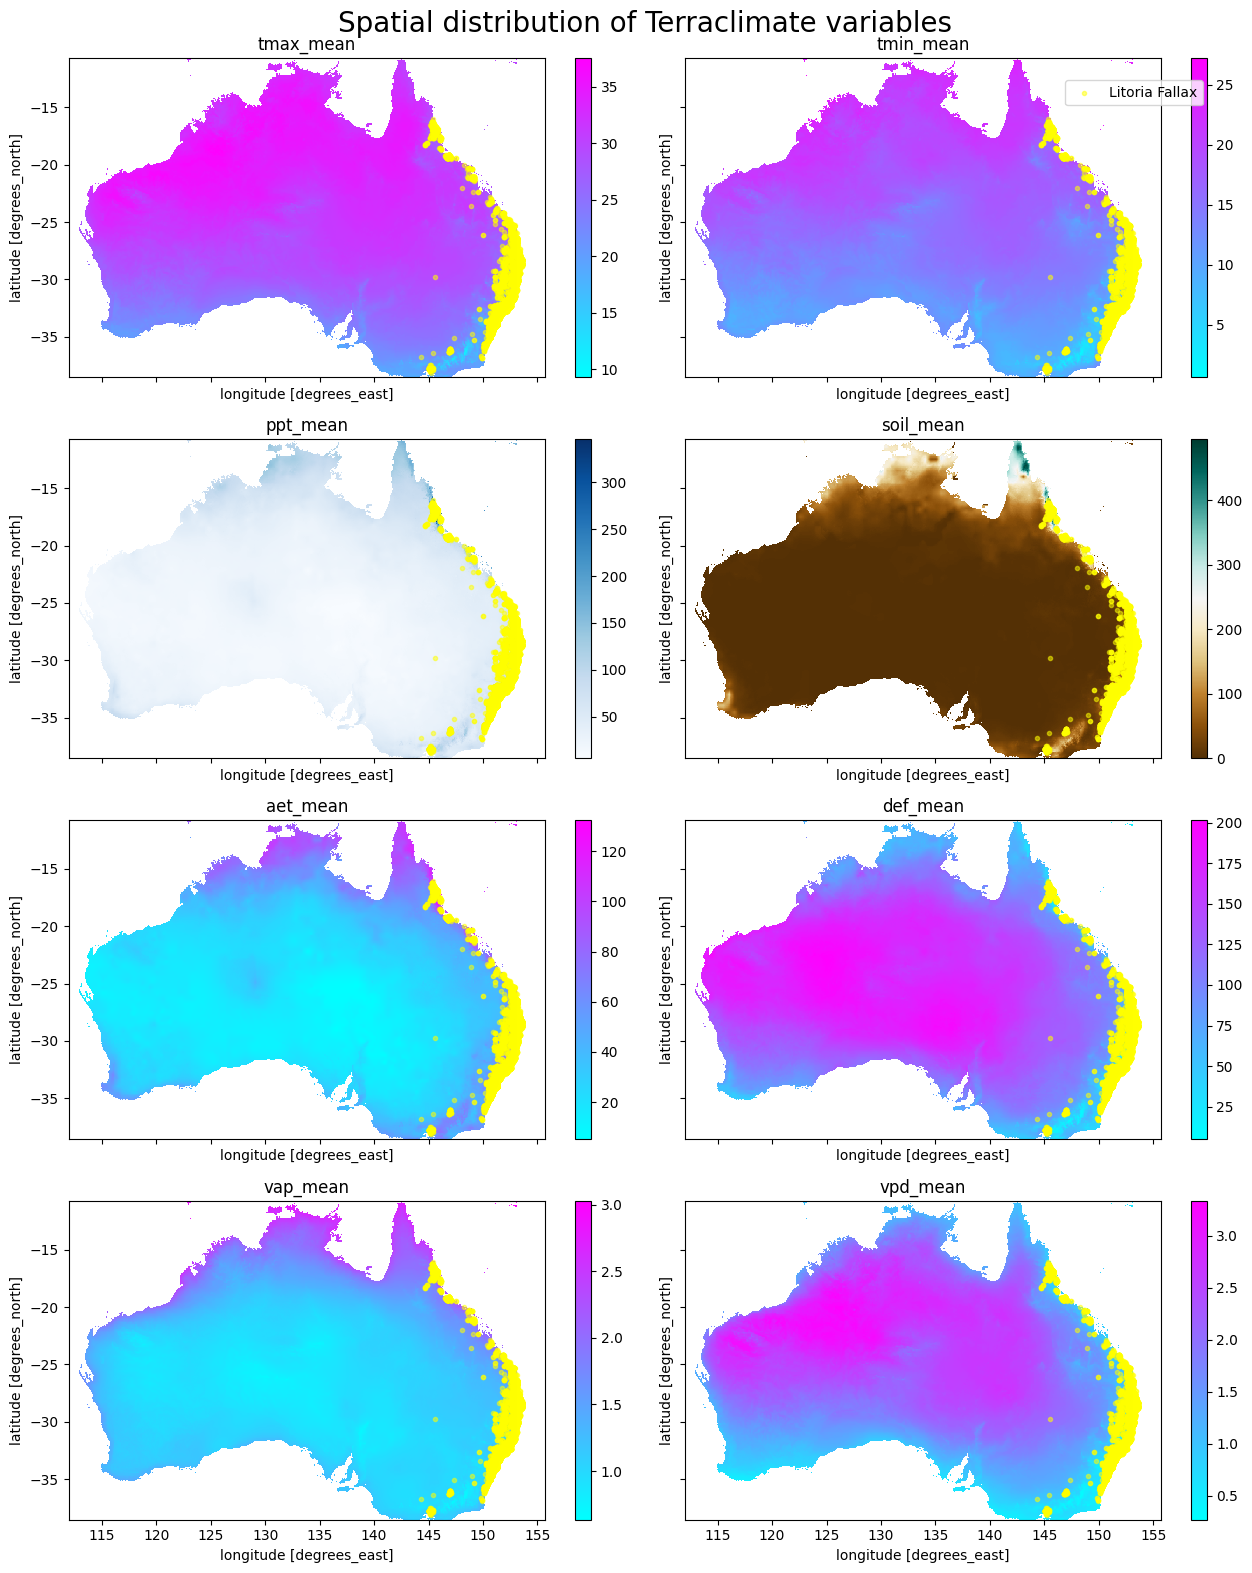

In [262]:
nrow = 4
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 16), sharex=True, sharey=True)

bands = weather_data.band.values
filt = frog_data.occurrenceStatus == 1
cmaps = ["cool", "cool", "Blues", "BrBG", "cool", "cool", "cool", "cool"]

for i in range(len(bands)):
    xr.plot.imshow(weather_data[i], 'x', 'y', cmap=cmaps[i], ax=ax[i//ncol, i%ncol])
    ax[i//ncol, i%ncol].set_title(bands[i])
    ax[i//ncol, i%ncol].scatter(frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
                                color = 'yellow', marker='.', alpha=0.5, label=target_species if i==0 else '')

fig.suptitle("Spatial distribution of Terraclimate variables", fontsize=20)
fig.legend(loc=(0.85, 0.933))
fig.tight_layout()

Text(0.5, 0.98, 'Frequency distribution of TerraClimate variables')

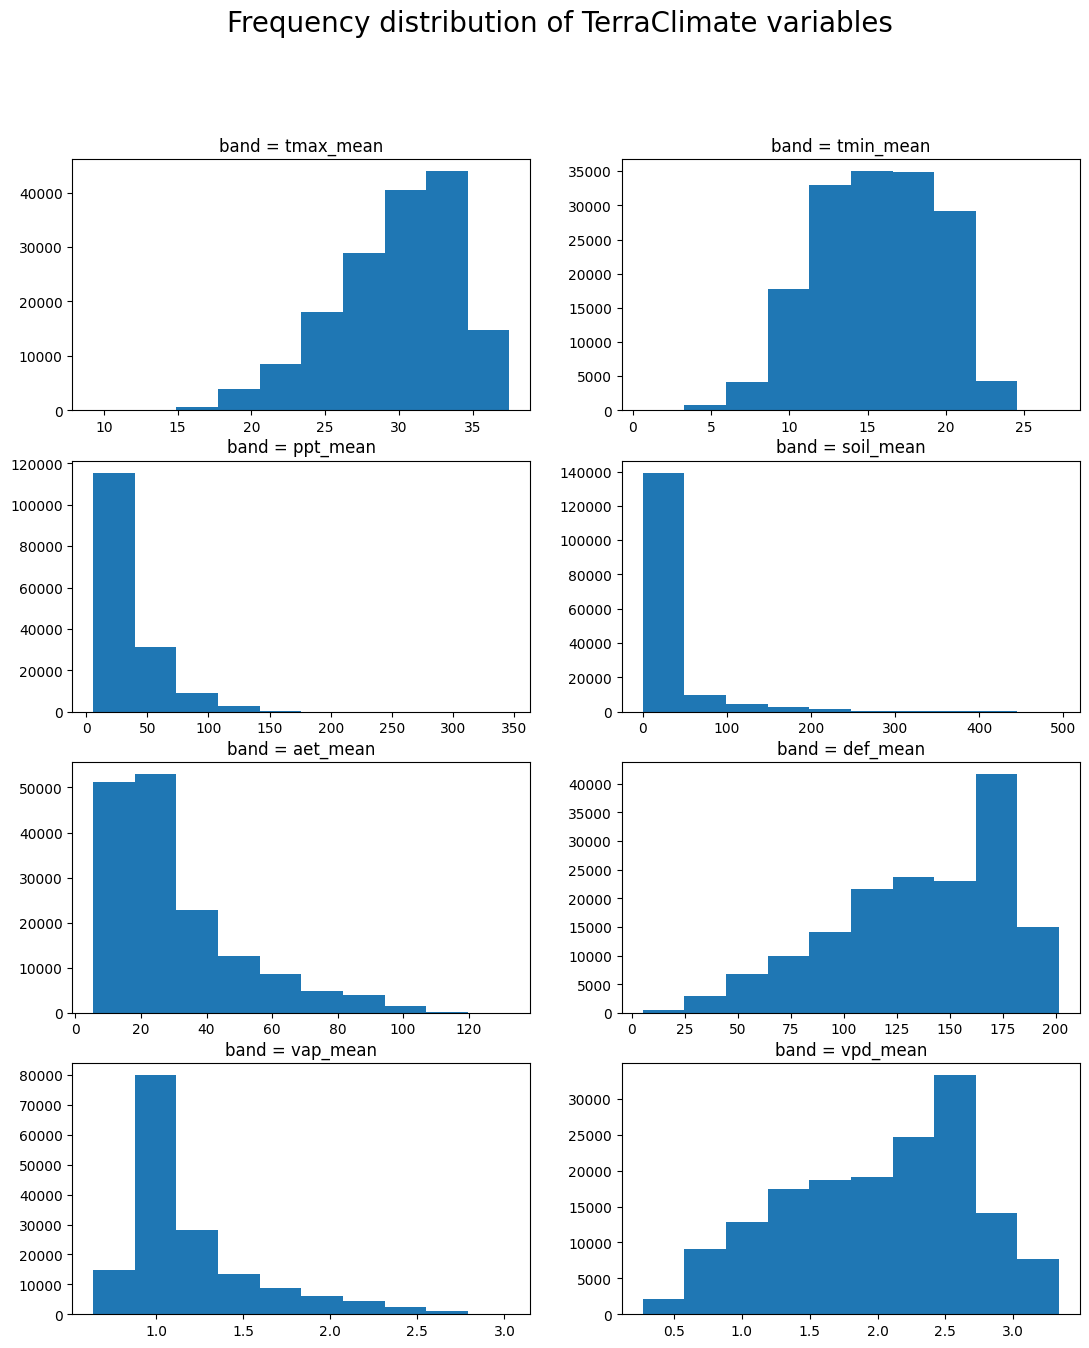

In [263]:
nrow = 4
ncol = 2
fig, ax = plt.subplots(nrow, ncol, figsize=(13, 15))

bands = weather_data.band.values

for i in range(len(bands)):
    xr.plot.hist(weather_data[i], ax=ax[i//ncol, i%ncol])

fig.suptitle("Frequency distribution of TerraClimate variables",  fontsize=20)

In [266]:
def join_frogs(frogs, data):
    """Collects the data for each frog location and joins it onto the frog data

    Arguments:
    frogs -- dataframe containing the response variable along with ["decimalLongitude", "decimalLatitude", "key"]
    data -- xarray dataarray of features, indexed with geocoordinates
    """
    return frogs.merge(
        (
            data
            .rename('data')
            .sel(
                x=xr.DataArray(frog_data.decimalLongitude, dims="key", coords={"key": frog_data.key}),
                y=xr.DataArray(frog_data.decimalLatitude, dims="key", coords={"key": frog_data.key}),
                method="nearest"
            )
            .to_dataframe()
            .assign(val = lambda x: x.iloc[:, -1])
            [['val']]
            .reset_index()
            .drop_duplicates()
            .pivot(index="key", columns="band", values="val")
            .reset_index()
        ),
        on = ['key'],
        how = 'inner'
    )

model_data = join_frogs(frog_data, weather_data)

model_data = model_data.drop(['gbifID', 'eventDate', 'level0Gid', 'species', 'Season', 'decimalLatitude', 'decimalLongitude', 'key'], axis=1)

model_data = model_data.dropna()

model_data

,occurrenceStatus,aet_mean,def_mean,ppt_mean,soil_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean
0,1,76.800001,41.940001,85.383333,77.081668,23.582333,13.792000,1.424467,0.758667
1,1,82.108334,30.450001,91.515000,95.556668,23.357666,10.982000,1.253717,0.769500
2,1,75.298335,45.136668,84.020000,73.623335,23.894999,13.936666,1.473683,0.737833
3,1,69.703335,44.031667,76.708333,57.541667,23.607166,12.524166,1.396533,0.722333
4,1,74.881668,53.628334,81.255000,67.093335,26.479499,15.132166,1.660700,0.913333
...,...,...,...,...,...,...,...,...,...
36666,0,65.441668,99.868335,72.776667,79.331668,34.256666,20.402166,1.918683,2.043833
36667,0,30.255001,102.096668,31.861667,9.076667,23.243333,10.818333,1.084150,1.044333
36668,0,75.725001,73.918335,90.478333,87.008335,32.634666,22.029166,2.442533,1.426000
36669,0,29.246667,157.046670,30.773333,9.415000,34.112166,19.313166,1.251817,2.653167


In [267]:
full_model = LogisticRegression()
# Separate the predictor variables from the response
X = (
    model_data
    .drop(['occurrenceStatus'], 1)
)
y = model_data.occurrenceStatus.astype(int)

# Fit model
full_model.fit(X, y)

LogisticRegression()

In [ ]:
X

,aet_mean,def_mean,ppt_mean,soil_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean
0,76.800001,41.940001,85.383333,77.081668,23.582333,13.792000,1.424467,0.758667
1,82.108334,30.450001,91.515000,95.556668,23.357666,10.982000,1.253717,0.769500
2,75.298335,45.136668,84.020000,73.623335,23.894999,13.936666,1.473683,0.737833
3,69.703335,44.031667,76.708333,57.541667,23.607166,12.524166,1.396533,0.722333
4,74.881668,53.628334,81.255000,67.093335,26.479499,15.132166,1.660700,0.913333
...,...,...,...,...,...,...,...,...
36666,65.441668,99.868335,72.776667,79.331668,34.256666,20.402166,1.918683,2.043833
36667,30.255001,102.096668,31.861667,9.076667,23.243333,10.818333,1.084150,1.044333
36668,75.725001,73.918335,90.478333,87.008335,32.634666,22.029166,2.442533,1.426000
36669,29.246667,157.046670,30.773333,9.415000,34.112166,19.313166,1.251817,2.653167


In [268]:
predictions = full_model.predict(X)

In [269]:
def predict_frogs(predictor_image, model):
    """Returns a (1, n, m) xarray where each pixel value corresponds to the probability of a frog occurrence.

    Takes in the multi-band image outputted by the `create_predictor_image` function as well as the
    trained model and returns the predictions for each pixel value. Firstly, the $x$ and $y$ indexes
    in the predictor image are stacked into one multi-index $z=(x, y)$ to produce an $k\times n$
    array, which is the format required to feed into our logistic regression model. Then, the array
    is fed into the model, returning the model's predictions for the frog likelihood at each pixel.
    The predicted probabilities are then indexed by the same multi-index $z$ as before, which allows
    the array to be unstacked and returned as a one-band image, ready for plotting.

    Arguments:
    predictor_image -- (K, n, m) xarray, where K is the number of predictor variables.
    model -- sklearn model with K predictor variables.
    """
    # Stack up pixels so they are in the appropriate format for the model
    predictor_image = predictor_image.stack(z=("y", "x")).transpose()
    # Reorder variables to be in same order as model
    predictor_image = predictor_image.sel(band=model.feature_names_in_)
    # Location of null values so that we can skip them (prediction model will break if nulls are present)
    null_pixels = (np.sum(predictor_image.isnull(), axis=-1) > 0)
    # Empty probabilities array
    probabilities = np.zeros((len(null_pixels), 2))
    # Calculate probability for each non-null pixel point
    probabilities[~null_pixels] = model.predict_proba(
        predictor_image[~null_pixels]
    )
    # Set null pixels to a probability of null
    probabilities[null_pixels] = np.array([np.nan, np.nan])
    # Just take probability of frog (class=1)
    probabilities = probabilities[:,1]
    # Add the coordinates to the probabilities, saving them in an xarray
    resultant_image = xr.DataArray(
        data=probabilities,
        dims=['z'],
        coords=dict(
            z=predictor_image.z
        )
    )
    # Unstack the image
    resultant_image = resultant_image.unstack()
    return resultant_image

# Calculate probability for each pixel point
resultant_image = predict_frogs(weather_data, full_model)

In [270]:
print(f"F1 Score: {np.mean(f1_score(y, predictions)).round(2)}")
print(f"Accuracy: {np.mean(accuracy_score(y, predictions)).round(2)}")

F1 Score: 0.98
Accuracy: 0.98


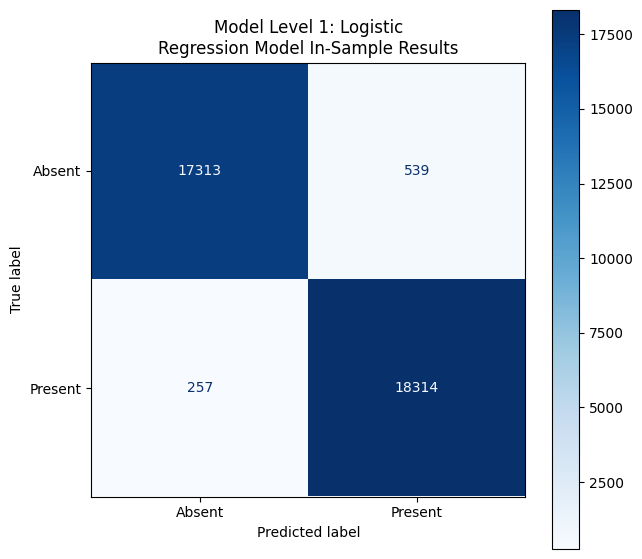

In [271]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(full_model, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

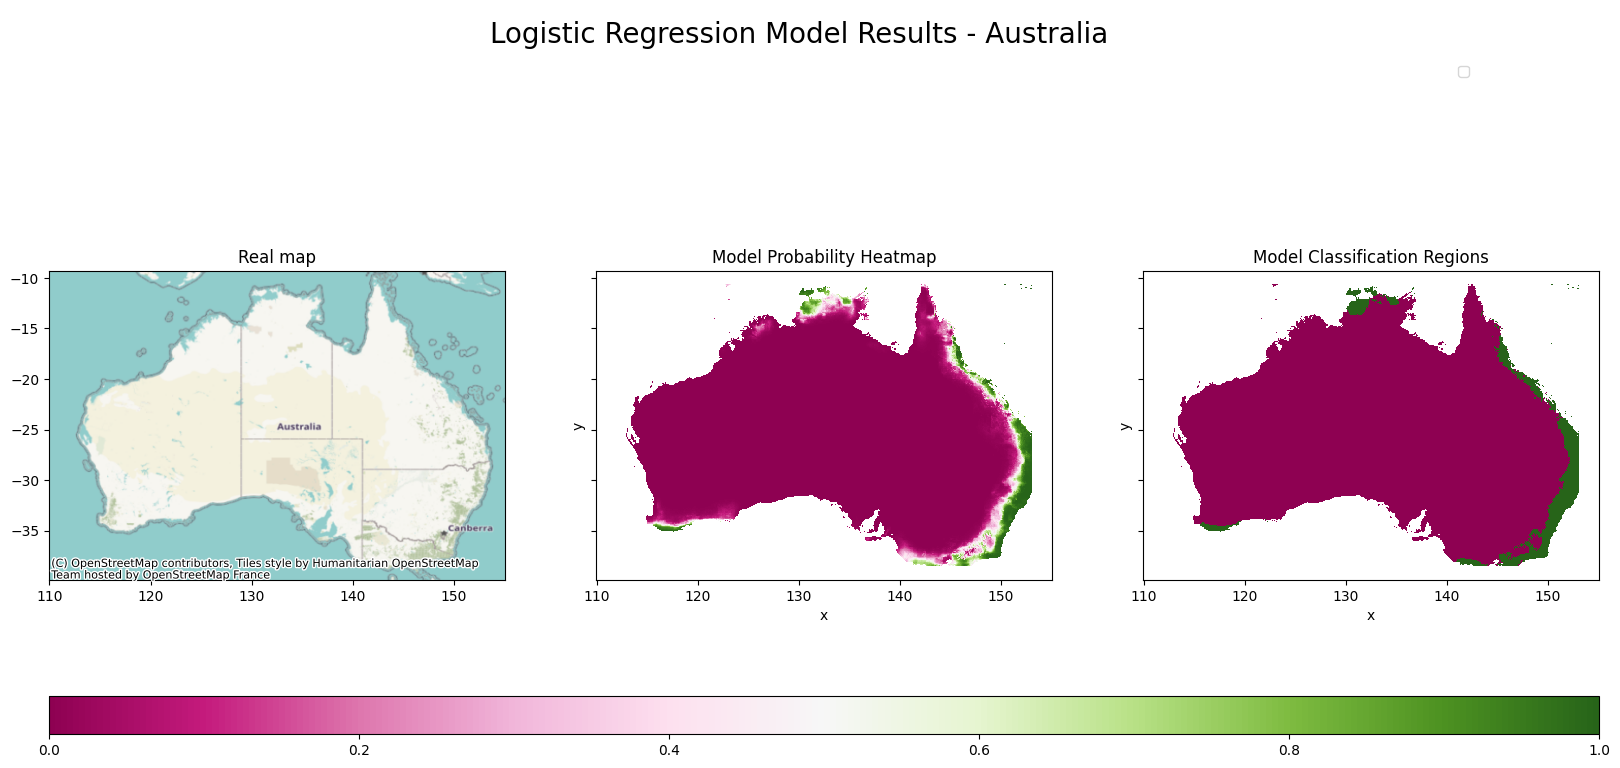

In [272]:
def plot_heatmap(resultant_image, frog_data, title, crs = {'init':'epsg:4326'}):
    """Plots a real map, probability heatmap, and model classification regions for the probability image from our model.

    Arguments:
    resultant_image -- (1, n, m) xarray of probabilities output from the model
    frog_data -- Dataframe of frog occurrences, indicated with a 1 in the occurrenceStatus column.
                 Must contain ["occurrenceStatus", "decimalLongitude", "decimalLatitude"]
    title -- string that will be displayed as the figure title
    crs -- coordinate reference system for plotting the real map. Defaults to EPSG:4326.
    """
    fig, ax = plt.subplots(1, 3, figsize = (20, 10), sharex=True, sharey=True)
    extent = [resultant_image.x.min(),resultant_image.x.max(),resultant_image.y.min(),resultant_image.y.max()]
    cmap = 'PiYG'

    # Plot real map
    ax[0].scatter(x=[extent[0], extent[1]], y=[extent[2], extent[3]], alpha=0)
    cx.add_basemap(ax[0], crs=crs)
    ax[0].set_title('Real map')

    # Plot heatmap from model
    heatmap = resultant_image.plot.imshow(
        x='x', y='y', ax=ax[1], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[1].set_aspect('equal')
    ax[1].set_title('Model Probability Heatmap')

    # Plot binary classification from model
    regions = xr.where(resultant_image.isnull(), np.nan, resultant_image>0.5).plot.imshow(
            x='x', y='y', ax=ax[2], cmap=cmap, vmin=0, vmax=1, interpolation='none', add_colorbar=False
    )
    ax[2].set_aspect('equal')
    ax[2].set_title('Model Classification Regions')

    # Plot real frogs
    # for i, axis in enumerate(ax):
    #     filt = frog_data.occurrenceStatus == 1
    #     axis.scatter(
    #         frog_data[filt].decimalLongitude, frog_data[filt].decimalLatitude,
    #         color = 'dodgerblue', marker='.', alpha=0.5, label='Target Species' if i==0 else ''
    #     )

    fig.colorbar(heatmap, ax=ax, location = 'bottom', aspect=40)
    fig.legend(loc = (0.9, 0.9))
    fig.suptitle(title, x=0.5, y=0.9, fontsize=20)

plot_heatmap(resultant_image, frog_data, f"Logistic Regression Model Results - {region_name}")

In [273]:
cv_model = LogisticRegression()

n_folds = 10

skf = StratifiedKFold(n_splits=n_folds, random_state=420, shuffle=True)
metrics = {'F1': f1_score, 'Accuracy': accuracy_score}
results = {'predicted':[], 'actual':[]}
scores = {'F1': [], 'Accuracy': []}

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the dataset
    print(f"Fold {i+1} of {n_folds}")
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model with the training set
    cv_model.fit(X_train, y_train)

    predictions = cv_model.predict(X_test)

    for metric, fn in metrics.items():
        scores[metric].append(fn(y_test, predictions))

    results['predicted'].extend(predictions)
    results['actual'].extend(list(y_test))

print(f'\nMetrics averaged over {n_folds} trials:')
for metric, result in scores.items():
    print(f"{metric}: {np.mean(result).round(2)}")


Fold 1 of 10
Fold 2 of 10
Fold 3 of 10
Fold 4 of 10
Fold 5 of 10
Fold 6 of 10
Fold 7 of 10
Fold 8 of 10
Fold 9 of 10
Fold 10 of 10

Metrics averaged over 10 trials:
F1: 0.98
Accuracy: 0.98


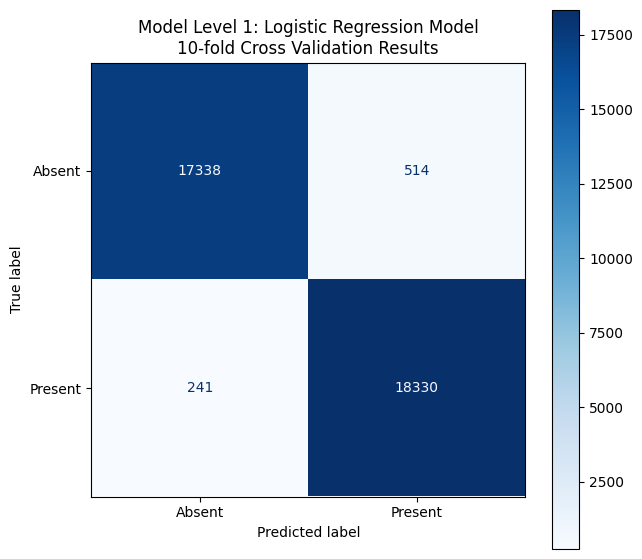

In [274]:
# Visualise the results in a confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(results['actual'], results['predicted'], display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((7, 7))
disp.ax_.set_title('Model Level 1: Logistic Regression Model\n10-fold Cross Validation Results')
plt.show()

In [275]:
# Load in test coordinates
test_file = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Info_Challenge/Level_1_challenge_1_submission_template.csv')
test_file

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.917146,145.207706,NaN
1,1,-37.750974,144.981501,NaN
2,2,-37.961600,145.348000,NaN
3,3,-37.621300,145.003000,NaN
4,4,-38.498100,145.647000,NaN
...,...,...,...,...
4046,4046,-31.884385,116.150192,NaN
4047,4047,-32.412962,115.779737,NaN
4048,4048,-32.147959,115.856628,NaN
4049,4049,-31.827000,116.238000,NaN


In [276]:
# Read in test regions
test_1_regions = []
with open('/content/drive/MyDrive/Colab Notebooks/Info_Challenge/challenge_1_test_regions.txt', 'r') as file:
    for i, line in enumerate(file):
        if i > 0:
            test_1_regions.append(eval("("+line+")"))

In [277]:
# Load in regions and save as list of dictionaries.
test_regions = [{'title':i, 'bbox':bbox} for i, bbox in enumerate(test_1_regions)]

Loading data
Calculating mean
Calculating min
Calculating max


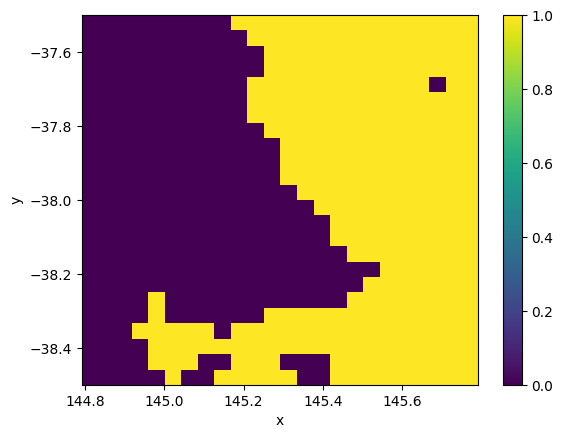

Loading data
Calculating mean
Calculating min
Calculating max


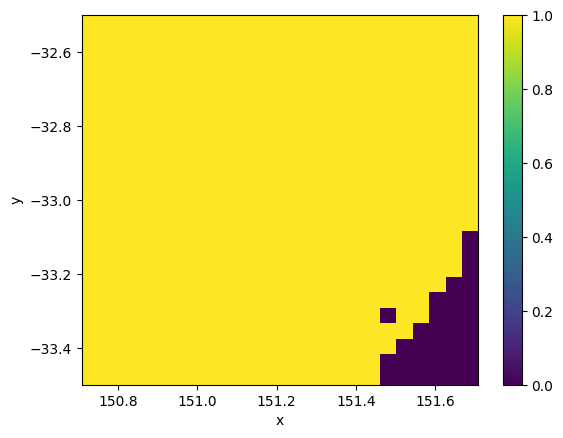

Loading data
Calculating mean
Calculating min
Calculating max


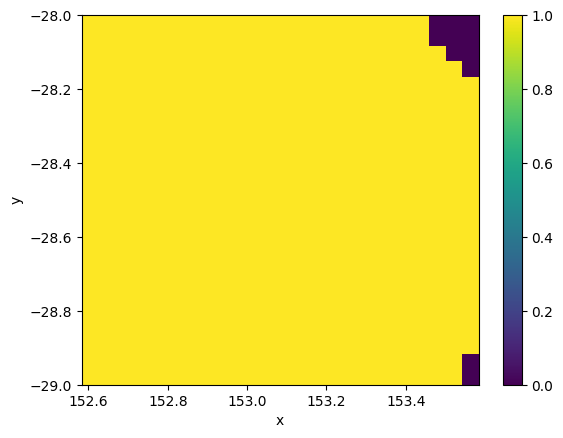

Loading data
Calculating mean
Calculating min
Calculating max


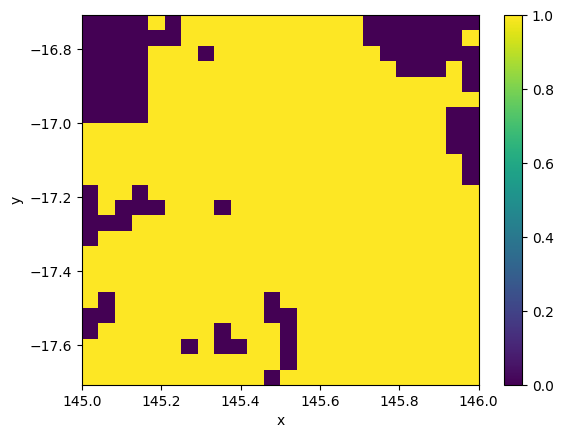

Loading data
Calculating mean
Calculating min
Calculating max


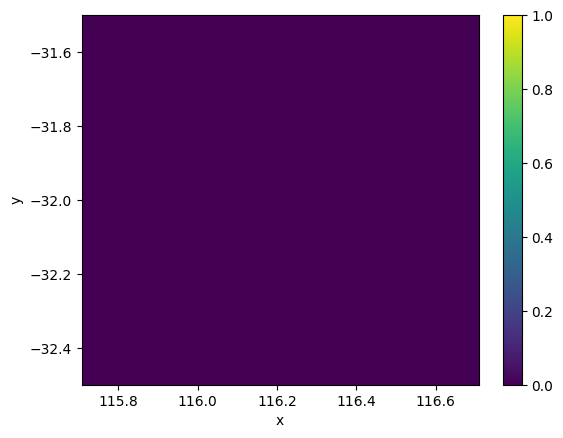

In [278]:
# Obtain predictor data for each region and get predictor image
for region in test_regions:
    region['coords'] = filter_bbox(test_file[['id', 'decimalLongitude', 'decimalLatitude']], region['bbox'])
    region['predictors'] = get_terraclimate(region['bbox'], tc_metrics, time_slice=('2017-01-01', '2019-12-31'), assets=assets, features=features)
    region['result'] = predict_frogs(region['predictors'], full_model) > 0.5

    region['result'].plot.imshow(x='x', y='y', vmin=0, vmax=1)
    plt.show()

In [279]:
predictions = pd.DataFrame()

for region in test_regions:
    preds = (
        region['result'].rename('occurrenceStatus')
        .sel(
            x=xr.DataArray(region['coords'].decimalLongitude, dims="id", coords={"id": region['coords'].id}),
            y=xr.DataArray(region['coords'].decimalLatitude, dims="id", coords={"id": region['coords'].id}),
            method="nearest"
        )
        .to_dataframe()
        .reset_index()
        .rename(columns={'x':'decimalLongitude', 'y':'decimalLatitude'})
    )
    predictions = predictions.append(preds)

submission = (
    predictions.merge(
        test_file,
        on=['decimalLongitude', 'decimalLatitude'],
        how='left', suffixes = ('', '_'))
    [test_file.columns]
    .fillna(0)
    .astype({col:'int' for col in test_file.columns[3::]})
)


In [280]:
display(submission)

# Save to output folder
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/Info_Challenge/IC24064_submission_4.csv', index=None)

,id,decimalLatitude,decimalLongitude,occurrenceStatus
0,0,-37.937500,145.187500,0
1,1,-37.770833,144.979167,0
2,2,-37.979167,145.354167,1
3,3,-37.604167,145.020833,0
4,4,-38.479167,145.645833,1
...,...,...,...,...
4046,4046,-31.895833,116.145833,0
4047,4047,-32.395833,115.770833,0
4048,4048,-32.145833,115.854167,0
4049,4049,-31.812500,116.229167,0
